In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## PREPERATON OF SPEED DATASET

In [111]:
path_speed = 'datasets/SPEED/DOT_Traffic_Speeds_NBE_20241001.csv'
df_speed = pd.read_csv(path_speed)
df_speed.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,TRANSCOM_ID,BOROUGH,LINK_NAME
0,263,0.00,0,-101,10/01/2024 06:29:03 AM,4763657,"40.60846,-74.03933 40.6107805,-74.03207 40.611...",{izvFxx{bMoMkl@_AiB_BaBqFkEwDgEkCeDcKiJ,BBBBBBBB,Verrazano-Narrows-Bridge,4763657,Brooklyn,GOW S VNB W 92ND STREET - BKLYN GANTRY LOWER L...
1,264,0.00,0,-101,10/01/2024 06:29:03 AM,4763655,"40.6083804,-74.039301 40.6107105,-74.03202 40....",kizvFrx{bMqMol@cAsByAcBsFkEoCgE}CqD_LeJ,BBBBBBBB,Verrazano-Narrows-Bridge,4763655,Brooklyn,GOW S VNB W 92ND STREET - BKLYN GANTRY UPPER L...
2,411,0.00,0,-101,10/01/2024 06:29:03 AM,4763652,"40.6040405,-74.052321 40.6047,-74.050301 40.60...",gnyvF~i~bMcCsKaPys@wBuJo@yC,BBBBB,Verrazano-Narrows-Bridge,4763652,Brooklyn,VNB E SI GANTRY UPPER LEVEL - BROOKLYN GANTRY ...
3,417,0.00,0,-101,10/01/2024 06:29:03 AM,4763649,"40.60414,-74.052411 40.60479,-74.050351 40.607...",{nyvFpj~bMaC{KcP{s@qBwJw@yC,BBBBB,Verrazano-Narrows-Bridge,4763649,Brooklyn,VNB W BROOKLYN GANTRY UPPER LEVEL - SI GANTRY ...
4,315,14.29,340,0,10/01/2024 06:29:03 AM,4616364,"40.73744001,-73.85188001 40.737015,-73.853730...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@\\|@`FbHz\fBvG,BBBBBBBBBB,NYC_DOT_LIC,4616364,Queens,LIE W 108TH ST - 84TH ST


In [112]:
df_speed_2024 = df_speed[df_speed['DATA_AS_OF'].str.contains('2024')] # Keep rows where 'DATA_AS_OF' contains '2024'
# df_speed_3_last_years = df_speed

# function for removing missing values
def remove_missing_values (df, df_name="Dataset"):
    missing_values = df.isnull().sum().sum()  # Total number of missing values
        
    if missing_values == 0:
        print(f"{df_name}: No missing values.")
    else:
        print(f"{df_name}: {missing_values} missing values found.")     
        print(f"Missing values per column in {df_name}:\n{df.isnull().sum()}")
        
        df_clean = df.dropna()      # Remove rows with missing values
        print(f"{df_name}: Cleaned dataset, removed rows with missing values.")
        return df_clean
    
    return df

df_speed_clean = remove_missing_values(df_speed_2024, "Traffic Speed Data 2024")

Traffic Speed Data 2024: No missing values.


In [113]:
print(df_speed_clean['BOROUGH'].unique())

['Brooklyn' 'Queens' 'Manhattan' 'Bronx' 'Staten Island']


In [114]:
df_speed_clean_copy = df_speed_clean.copy() # Avoid tampering with original dataset

df_speed_clean_copy['DATA_AS_OF'] = pd.to_datetime(df_speed_clean_copy['DATA_AS_OF'])           # Convert 'DATA_AS_OF' column to datetime format
df_speed_clean_copy.set_index('DATA_AS_OF', inplace=True)                                       # Set 'DATA_AS_OF' as the index

df_hourly_avg_speed = df_speed_clean_copy.groupby('BOROUGH').resample('H').mean().reset_index() # Resample the data by hour and calculate the mean speed for each borough
df_hourly_avg_speed['Hour'] = df_hourly_avg_speed['DATA_AS_OF'].dt.hour                         # Extract the hour from 'DATA_AS_OF'

df_mean_spead = df_hourly_avg_speed.groupby(['BOROUGH', 'Hour'])['SPEED'].mean().reset_index()    # Group by the borough and hour, calculate average speed across all dates per borough
df_mean_spead.rename(columns={'SPEED': ''}, inplace=True)                                         # Rename columns for clarity

print(df_mean_spead)


           BOROUGH  Hour           
0            Bronx     0  39.066408
1            Bronx     1  40.652314
2            Bronx     2  41.506554
3            Bronx     3  42.275486
4            Bronx     4  42.864847
..             ...   ...        ...
115  Staten Island    19  31.870806
116  Staten Island    20  33.866476
117  Staten Island    21  35.068609
118  Staten Island    22  35.393288
119  Staten Island    23  35.941647

[120 rows x 3 columns]


In [115]:
# Create a 'Month' column to extract the month from 'DATA_AS_OF'
df_hourly_avg_speed['Month'] = pd.to_datetime(df_hourly_avg_speed['DATA_AS_OF']).dt.month
df_hourly_avg_speed

# Assign seasons:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'  

# Apply the function to create a 'Season' column
df_hourly_avg_speed['Season'] = df_hourly_avg_speed['Month'].apply(assign_season)


In [162]:
seasonal_speed = df_hourly_avg_speed.groupby(['Season', 'Hour'])['SPEED'].mean().unstack()
print(seasonal_speed)

with open('df_speed.pkl', 'wb') as f:
    pickle.dump(df_hourly_avg_speed, f)

with open('df_seasonal_speed.pkl', 'wb') as f:
    pickle.dump(seasonal_speed, f)



Hour           0          1          2          3          4          5   \
Season                                                                     
Autumn  31.215625  32.436335  33.315395  34.284927  35.465976  35.435401   
Spring  30.930098  31.762357  32.489419  33.334536  34.460258  34.459636   
Summer  31.575330  32.666920  33.552263  34.302902  35.757753  36.047039   
Winter  33.179240  33.347055  33.700334  34.568948  35.451585  35.370941   

Hour           6          7          8          9   ...         14         15  \
Season                                              ...                         
Autumn  30.867001  28.176126  26.304287  26.349509  ...  23.948571  22.320087   
Spring  30.555417  27.867530  26.402634  26.320406  ...  23.138777  21.312331   
Summer  33.068850  30.591861  28.499463  27.737192  ...  24.375007  23.259612   
Winter  31.606355  29.702763  28.604897  29.046959  ...  27.203187  25.458156   

Hour           16         17         18         19      

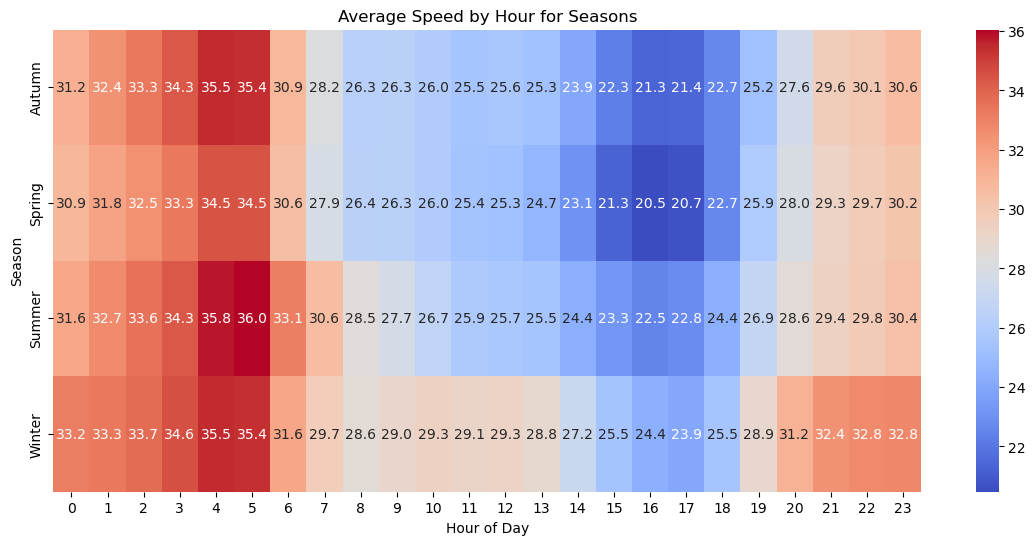

In [128]:
plt.figure(figsize=(14, 6))
sns.heatmap(seasonal_speed, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Average Speed by Hour for Seasons')
plt.xlabel('Hour of Day')
plt.ylabel('Season')
plt.show()

<Figure size 1000x600 with 0 Axes>

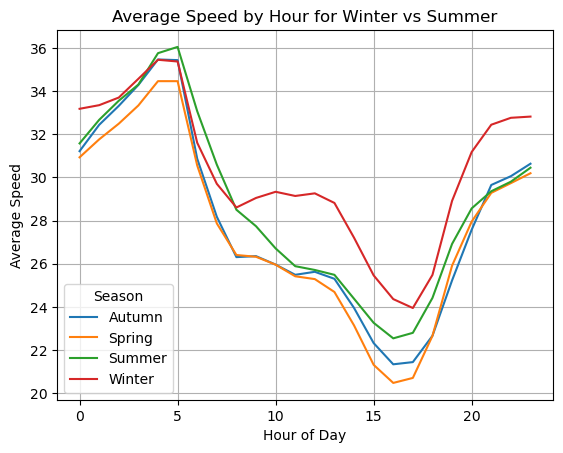

In [118]:
# Plot the average speed for each season over time (hours)
plt.figure(figsize=(10, 6))
seasonal_speed.T.plot(kind='line')
plt.title('Average Speed by Hour for Winter vs Summer')
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed')
plt.grid(True)
plt.legend(title='Season')
plt.show()




## PREPERATON OF VOLUME DATASET

In [153]:
volume_dfs = []
# Define paths to CSV files in a list
csv_paths = [
    'datasets/VOL/31_AVENUE.csv',
    'datasets/VOL/120_AVENUE.csv',
    'datasets/VOL/126_STREET.csv',
    'datasets/VOL/MAIN_STREET.csv',
    'datasets/VOL/SANFORD_AVENUE.csv'
]

# Iterate through each CSV file, standardize 'Roadway Name', and check differences
for path in csv_paths:
    df = pd.read_csv(path)
    df['Roadway Name'] = df['Roadway Name'].str.upper().str.strip()  # Standardize column

    # Find unique values in 'Roadway Name' column
    unique_roadway_names = df['Roadway Name'].unique()

    # Print the unique values for each dataset
    print(f"Dataset: {path}")
    print(f"Unique 'Roadway Name' values: {unique_roadway_names}\n")

    first_value = df['Roadway Name'].unique()[0]
    df['Roadway Name'] = first_value
    df['Month'] = pd.to_datetime(df['Date']).dt.month   # Create month column
    df['Season'] = df['Month'].apply(assign_season)


    # Check for missing seasons
    seasons_present = df['Season'].unique()
    expected_seasons = {'Winter', 'Spring', 'Summer', 'Autumn'}
    missing_seasons = expected_seasons - set(seasons_present)

    if missing_seasons:
        print(f"Dataset: {path}")
        print(f"Warning: Missing seasons in the data: {missing_seasons}\n")


    df_vol_cleaned = remove_missing_values(df, "Traffic Vol Data")

    volume_dfs.append(df_vol_cleaned)



# Save the list of DataFrames to a file
with open('df_vol_separate.pkl', 'wb') as f:
    pickle.dump(volume_dfs, f)


# Concat and save DataFrames to a file
df_vol_combined = pd.concat(volume_dfs, ignore_index=True)
with open('df_vol_combined.pkl', 'wb') as f:
    pickle.dump(df_vol_combined, f)

Dataset: datasets/VOL/31_AVENUE.csv
Unique 'Roadway Name' values: ['31 AVENUE' '31ST AVENUE']

Dataset: datasets/VOL/31_AVENUE.csv

Traffic Vol Data: 24 missing values found.
Missing values per column in Traffic Vol Data:
ID               0
SegmentID        0
Roadway Name     0
From             0
To               0
Direction        0
Date             0
12:00-1:00 AM    0
1:00-2:00AM      0
2:00-3:00AM      0
3:00-4:00AM      0
4:00-5:00AM      0
5:00-6:00AM      0
6:00-7:00AM      0
7:00-8:00AM      0
8:00-9:00AM      0
9:00-10:00AM     0
10:00-11:00AM    0
11:00-12:00PM    0
12:00-1:00PM     2
1:00-2:00PM      2
2:00-3:00PM      2
3:00-4:00PM      2
4:00-5:00PM      2
5:00-6:00PM      2
6:00-7:00PM      2
7:00-8:00PM      2
8:00-9:00PM      2
9:00-10:00PM     2
10:00-11:00PM    2
11:00-12:00AM    2
Month            0
Season           0
dtype: int64
Traffic Vol Data: Cleaned dataset, removed rows with missing values.
Dataset: datasets/VOL/120_AVENUE.csv
Unique 'Roadway Name' values: ['

In [148]:
unique_months = df_vol_combined['Month'].unique()
print("Unique Months:", unique_months)

Unique Months: [ 1 10  3 11  2  9  5  4]


In [149]:
df_vol_combined

,ID,SegmentID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,Month,Season
0,1929,76510,31 AVENUE,87 STREET,88 STREET,EB,01/25/2012,56,32,26,...,241.0,304.0,236.0,185.0,129.0,105.0,94.0,66.0,1,Winter
1,1930,76510,31 AVENUE,87 STREET,88 STREET,EB,01/26/2012,55,29,21,...,235.0,281.0,262.0,190.0,127.0,124.0,83.0,55.0,1,Winter
2,1931,76510,31 AVENUE,87 STREET,88 STREET,EB,01/27/2012,45,31,20,...,258.0,294.0,290.0,193.0,169.0,136.0,113.0,85.0,1,Winter
3,1932,76510,31 AVENUE,87 STREET,88 STREET,EB,01/28/2012,101,53,52,...,235.0,251.0,222.0,175.0,165.0,151.0,136.0,125.0,1,Winter
4,1933,76510,31 AVENUE,87 STREET,88 STREET,EB,01/29/2012,118,96,84,...,184.0,163.0,195.0,177.0,144.0,117.0,95.0,67.0,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,302,91529,SANFORD AVE,147th Street,149th Street,WB,11/18/2020,35,17,12,...,278.0,308.0,234.0,207.0,152.0,125.0,95.0,53.0,11,Autumn
326,302,91529,SANFORD AVE,147th Street,149th Street,WB,11/19/2020,44,17,5,...,282.0,290.0,251.0,241.0,194.0,113.0,93.0,59.0,11,Autumn
327,302,91529,SANFORD AVE,147th Street,149th Street,WB,11/20/2020,33,18,18,...,300.0,305.0,268.0,232.0,212.0,150.0,140.0,82.0,11,Autumn
328,302,91529,SANFORD AVE,147th Street,149th Street,WB,11/21/2020,51,28,20,...,293.0,318.0,235.0,270.0,181.0,127.0,120.0,75.0,11,Autumn


In [161]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_melt = df_vol_combined.copy()

# Rename columns representing hours to 0-23 for simplicity
hourly_columns = df_melt.columns[7:-2]  # Assuming hourly columns start at index 7 and go to the second to last column
new_column_names = list(range(24))  # Creating new names for the hours (0-23)
rename_dict = dict(zip(hourly_columns, new_column_names))  # Creating a mapping dictionary

df_melt.rename(columns=rename_dict, inplace=True)

# Melt the dataset to convert hourly columns (0-23) into rows
# Include 'Roadway Name' in id_vars to keep it intact
df_vol_season_melt = df_melt.melt(id_vars=['Season', 'Roadway Name'],
                                  value_vars=new_column_names,
                                  var_name='Hour',
                                  value_name='Volume')


with open('df_vol_melt.pkl', 'wb') as f:
    pickle.dump(df_vol_season_melt, f)


In [158]:
df_vol_season_melt

,Season,Roadway Name,Hour,Volume
0,Winter,31 AVENUE,0,56.0
1,Winter,31 AVENUE,0,55.0
2,Winter,31 AVENUE,0,45.0
3,Winter,31 AVENUE,0,101.0
4,Winter,31 AVENUE,0,118.0
...,...,...,...,...
7915,Autumn,SANFORD AVE,23,53.0
7916,Autumn,SANFORD AVE,23,59.0
7917,Autumn,SANFORD AVE,23,82.0
7918,Autumn,SANFORD AVE,23,75.0


In [146]:
unique_months = df_vol_combined['Month'].unique()
print("Unique Months:", unique_months)

Unique Months: [ 1 10  3 11  2  9  5  4]
